# Emotion Patterns in Music Playlists

Please refer to [https://github.com/sgiammy/emotion-patterns-in-music-playlists](https://github.com/sgiammy/emotion-patterns-in-music-playlists) for more details on the code which is used in this notebook.

In [1]:
import spacy
import os
import sys

import numpy as np
import pandas as pd

from sklearn.model_selection import cross_val_score

from sklearn.model_selection import GridSearchCV

import seaborn as sns
import matplotlib.pyplot as plt

from utils.datasets import load_dataset_from_path, split_train_validation

lyrics_path = './ml_lyrics'

emotion_labels = ['happy', 'sad', 'relaxed', 'angry']

In [2]:
def parameters_grid_search(classifier, params, x, y, cv=10, verbose=False):
    """
    Grid Search to find best parameters for a certain classifier whose
    performances are evaluated using cross-validation
    """
    gs = GridSearchCV(classifier(), params, cv=cv, n_jobs=-1, verbose=verbose)
    gs.fit(x, y)    
    return (gs.best_estimator_, gs.best_params_)

This notebook has the sole purpose of providing us an experimental environment in which we can quickly test our intuitions and ideas. Therefore, even though for the final algorithm we will use FastText, for this notebook we will use a pre-trainend language model available in spaCy containing 20k unique vectors trained on Common Crawl.

For more information about the language model we are using, please refer to [this](https://spacy.io/models/en) link.

In [3]:
# For this notebook we will use a simple spacy vocabulary
# because we just need to do some experiments
nlp = spacy.load('en_core_web_md')

# 1. The Dataset: MoodyLyrics

In the followign section we will provide some interesting statistics on the dataset we will be using throughtout the notebook: MoodyLyrics.

**DISCLAIMER**: this notebook assumes that MoodyLyrics song lyrics have been downloaded using the script provided with this notebook into a folder named `ml_lyrics`.

Firstly, let's see how many lyrics we have in our dataset.

In [48]:
%%bash
ls -1 ml_lyrics/ | wc -l

2452


In MoodyLyrics we have 4 different emotion labels for our songs: happy, sad, relaxed and angry. Let's see how those 4 classes are distributed.

In [68]:
count = dict(list(zip(emotion_labels, [0 for x in range(len(emotion_labels))])))

# Traverse the dataset directory
for root, dirs, files in os.walk(lyrics_path):
    for f in files:
        fields = f.split('_')
        if len(fields) > 0:
            count[fields[0]] += 1

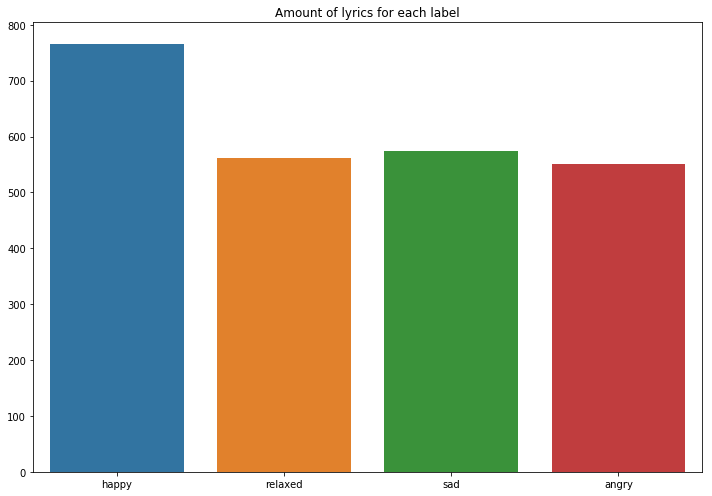

In [74]:
# Plot the obtained counts
# Plot
fig, ax = plt.subplots()
fig.set_size_inches(10, 7)
ax = sns.barplot(x=list(count.keys()), y=list(count.values()), ax=ax)
ax.set_title('Amount of lyrics for each label')
plt.tight_layout()
plt.show()

As we can see our lyrics are quite balanced among the 4 different classes. Only the happy class has some more lyrics with respect to the other threes. However we believe that it is not going to be a problem as the different between happy and other lyrics should not be too relevant.

# 2. Lyrics Preprocessing

Now we will move on analyzing several techniques for lyrics preprocessing, eventually evaluating their effects and their performances.

## 2.1. Stopwords deletion

In one of our meetings for our project an interesting question was raised: does it really make sense to remove stopwords from lyrics? Would we have enough words after removing stopwords? Let's see what is the percentage change in the amount of words in our lyrics after removing stopwords. 

In [4]:
def remove_stopwords(doc):
    tks = list(filter(lambda tk: not tk.is_stop, doc))
    return spacy.tokens.Doc(nlp.vocab, words=[tk.text for tk in tks])

In [ ]:
paths = load_dataset_from_path(lyrics_path)['Lyric_Path'].as_matrix()

# Build a dataframe with the following schema:
# <song, words, words_after_stopwords_removal, percentage_change>
rows = list()

for path in paths:
    with open(path, 'r') as f:
        doc = nlp(f.read())
        n_words_before = len(doc)
        doc = remove_stopwords(doc)
        n_words_after = len(doc)
        perc = (n_words_before - n_words_after) / n_words_before * 100
        row = (path, n_words_before, n_words_after, perc)
        rows.append(row)

# Create a dataframe with the found information
df = pd.DataFrame(rows, columns=['Lyric', 'Word_Count', 
                  'Word_Count_After', 'Percentage_Change'])

In [5]:
# Print some statistics
percs = [ 25, 30, 40, 50, 60, 75 ]
print('Percentage of change in lyrics after removing stopwords:')
it = enumerate(percs)
plt_data = list()
for (i, perc) in it:
    if i == 0: 
        count = len(df[df['Percentage_Change'] < perc])
        print(' - < {}: {}'.format(perc, count))
        plt_data.append(('< {}'.format(perc), count))
    elif i == len(percs) - 1:
        count = len(df[df['Percentage_Change'] >= perc])
        print(' - >= {}: {}'.format(perc, count))
        plt_data.append(('>= {}'.format(perc), count))
    else:
        prev_p = percs[i-1]
        count = len(df[(df['Percentage_Change'] >= prev_p) & (df['Percentage_Change'] < perc)])
        print(' - between {} and {}: {}'.format(prev_p, perc, count))
        plt_data.append(('>= {} and < {}'.format(prev_p, perc, count), count))

pltDf = pd.DataFrame(plt_data)
print(pltDf)

Percentage of change in lyrics after removing stopwords:
 - < 25: 2453
 - between 25 and 30: 0
 - between 30 and 40: 0
 - between 40 and 50: 0
 - between 50 and 60: 0
 - >= 75: 0
                0     1
0            < 25  2453
1  >= 25 and < 30     0
2  >= 30 and < 40     0
3  >= 40 and < 50     0
4  >= 50 and < 60     0
5           >= 75     0


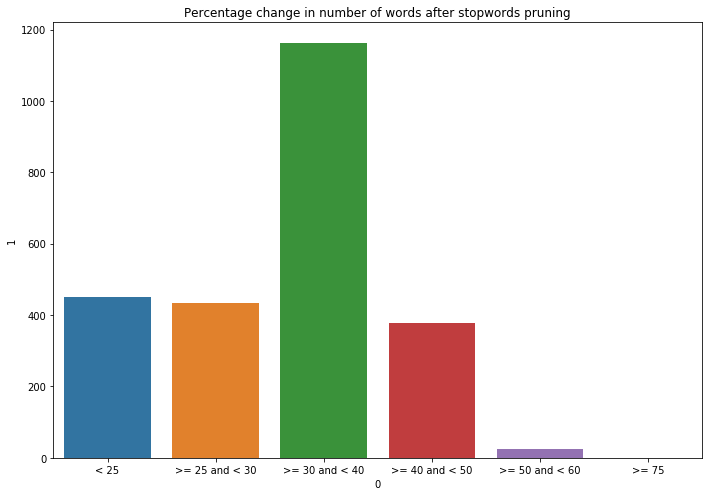

In [12]:
# Plot
fig, ax = plt.subplots()
fig.set_size_inches(10, 7)
ax = sns.barplot(pltDf[0], pltDf[1], ax=ax)
ax.set_title('Percentage change in number of words after stopwords pruning')
plt.tight_layout()
plt.show()

As we can see from the above plot, there is a minimum (but still relevant to our purpose) impact on lyrics, which still have a large number of words to be analyzed. Only 25 songs reduced their size of more then the 50% and for those songs we may probably have some problems. However this is a really small amount of lyrics that does not prevent us from saying that stopword deletion can be used as a pre-processing technique for our model.

## 2.2. Preprocessing Function
Now that we have defined which kind of preprocessing is good to apply to the text of our songs, let's define a function which will be used throughout the notebook to perform lyrics preprocessing.

In [6]:
def doc_preprocess(doc):
    d = remove_stopwords(doc)
    return d

# 3. Feature Engineering
We will now move on trying to extract some interesting feature from our dataset. 

An important thing we need to state before starting analyzing this section, is that, by using spaCy's `en_core_web_md` language model, each document has a word vector of length 300.

## 3.1. Principal Component Analysis (PCA)

## 3.2 Feature Engineering Function
Now that we have defined which kind of feature engineering we want to, let's define a function which will be used throughout the notebook to perform the desired operations on the dataset.

In [7]:
def feature_engineer(dataset):
    return dataset

# 3. Classifiers
In the next sections we will provide the implementation of several classification algorithms we used.

First, let's prepare the data for those classifiers.

In [8]:
# Read dataset into pandas dataframe
dataset = load_dataset_from_path(lyrics_path)

# Turn emotion labels into numerical features
mapping = dict(zip(emotion_labels, range(len(emotion_labels)))) # { 'happy' : 0, 'sad': 1, 'relaxed': 2, 'angry': 3 }
dataset['Emotion'] = dataset['Emotion'].map(mapping)

# Make the dataset to follow this scema:
# <Lyric_Path, Emotion, Vector, Vector_Norm>
rows = list()
dataset['Vector'] = np.nan
dataset['Vector_Norm'] = np.nan
for index, row in dataset.iterrows():
    lyric = row['Lyric_Path']
    emotion = row['Emotion']
    with open(lyric, 'r') as lyric_file: 
        doc = nlp(lyric_file.read())
        doc = doc_preprocess(doc) # Preprocessing step
        # Consider only those vectors with the same length
        # This will be avoided when we will have proper PCA
        if len(doc.vector) == 300:
            rows.append((
                lyric,
                emotion, doc.vector,
                doc.vector_norm
            ))
dataset = pd.DataFrame(rows, columns=['Lyric_Path', 'Emotion', 'Vector', 'Vector_Norm'])
dataset = feature_engineer(dataset) # Do feature engineering
# Show some dataset's values
dataset.head()

,Lyric_Path,Emotion,Vector,Vector_Norm
0,/home/mario/dev/emotion-patterns-in-music-play...,3,"[0.050857957, 0.20104454, -0.23816079, -0.0809...",3.284478
1,/home/mario/dev/emotion-patterns-in-music-play...,0,"[-0.0055046813, 0.21067859, -0.24720527, -0.03...",3.245214
2,/home/mario/dev/emotion-patterns-in-music-play...,0,"[-0.026111318, 0.3005838, -0.17116451, -0.0483...",3.175837
3,/home/mario/dev/emotion-patterns-in-music-play...,1,"[0.034401078, 0.13464417, -0.15250482, -0.0580...",2.923467
4,/home/mario/dev/emotion-patterns-in-music-play...,3,"[-0.032687973, 0.19538553, -0.23822886, -0.019...",3.243524


In [9]:
# Prepare array for sklearn classifiers
X_vect = dataset['Vector'].as_matrix().T
X_vect = np.array([np.array(x) for x in X_vect])
X_norm = dataset['Vector_Norm'].as_matrix()
y = dataset['Emotion'].as_matrix()

## 3.1. Supervised K-Means
This is the first and the easieast classifier idea we came up. We used this idea just to verify what we could do and if we were on the right path. 

The name we gave to this classifier could sound ambiguous but we believe that, once its functioning is explained, the name will sound more decent.

The idea behind this classifier is quite simple. The first thing we do is to compute the centroids for each emotion class. Then, to classify a lyric, we simply compare its word vector norm to the 4 centroids. At the end we will assign our lyric with the label of the closest "cluster".

In [55]:
from classifier.LyricsSupervisedKMeans import LyricsSupervisedKMeans

class LyricsSupervisedKMeans(LyricsSupervisedKMeans):
    def train(self, X_train, y):
        self.target_dict = dict(list(zip(range(len(self.labels)), [0 for x in range(len(self.labels))])))
    
        for (x,y) in zip(X_train, y):
            self.target_dict[y] += x

        for k in self.target_dict.keys():
            self.target_dict[k] /= len(X_train)

In [57]:
clf = LyricsSupervisedKMeans()
clf.set_lang(nlp)

# Split dataset into training and test sets
trainDf, testDf = split_train_validation(dataset)

X_sup_kmeans_train = trainDf['Vector'].as_matrix().T
X_sup_kmeans_train = np.array([np.array(x) for x in X_sup_kmeans_train])

y_sup_kmeans_train = trainDf['Emotion'].as_matrix()

# Train our model
clf.train(X_sup_kmeans_train, y_sup_kmeans_train)

# Evaluate accuracy
acc = clf.score(testDf)
print('Accuracy: %0.2f' % (acc))

Accuracy: 0.32


For this model we did not even implement cross-validation. We just split the dataset into a training set (90%) and a test set (10%) and we evaluated the classification accuracy on that test set. We decided not to implement cross-validation for this classifier as we believe it is not worth to spend time on it.

We were expecting poor results from this classifier but at least it served to the purpose of giving us a hint of which direction to follow.

## 3.2. k-Nearest Neighbour
We will now build a k-NN model which is basically a generalization of what we called "Supervised K-Means". We will evaluate our model for several different k values. The parameters passed to our model are quite self-explicative.

In [148]:
from sklearn.neighbors import KNeighborsClassifier

ks = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21]

for k in ks:
    # Build model
    clf = KNeighborsClassifier(n_neighbors=k, algorithm='auto', 
                           metric='euclidean', n_jobs=-1)
    # Evaluate accuracy
    scores = cross_val_score(clf, X_vect, y, cv=10)
    print('Accuracy for k=%d: %0.2f (+/- %0.2f)' % (k, scores.mean(), scores.std() * 2))

Accuracy for k=1: 0.72 (+/- 0.03)
Accuracy for k=3: 0.73 (+/- 0.05)
Accuracy for k=5: 0.73 (+/- 0.04)
Accuracy for k=7: 0.74 (+/- 0.05)
Accuracy for k=9: 0.75 (+/- 0.03)
Accuracy for k=11: 0.75 (+/- 0.04)
Accuracy for k=13: 0.75 (+/- 0.04)
Accuracy for k=15: 0.75 (+/- 0.03)
Accuracy for k=17: 0.74 (+/- 0.05)
Accuracy for k=19: 0.74 (+/- 0.05)
Accuracy for k=21: 0.75 (+/- 0.05)


The k-NN algorithm produced unexpectedly good results. As we can see the algorithm never reaches an accuracy value higher than 75%. From our observations we can conclude that `k=9` could be an good parameter for that model.

Those results are encouraging and make us believe that we can certainly do even better.

## 3.3. SVM
We will now train a Support Vector Machine using the algorithm available in sklearn. After a brief manual tuning step, we found our that this model has good accuracy when using the [Radial Basis Function](https://en.wikipedia.org/wiki/Radial_basis_function) as a kernel.

In [182]:
from sklearn.svm import SVC

# Build model
clf = SVC(kernel='rbf', C=150)
# Evaluate accuracy
scores = cross_val_score(clf, X_vect, y, cv=10)
print('Accuracy: %0.2f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

Accuracy: 0.89 (+/- 0.05)


Now let's see if we can improve our model's accuracy just my properly tuning our parameters. We will perform a [Grid Search](http://scikit-learn.org/stable/modules/grid_search.html) to properly tune our model using a cross validation approach to evaluating accuracy. We will operate on both the kernel function and the penalty parameter C.

Beware that the below cell takes quite a long time to run as the `SVC` train function complexity is more than quadratic and, having to run it several times, is quite expensive.

In [176]:
# Define the set of parameters we want to test on
params = [
    { 'kernel': ['linear'], 'C': [ 0.01, 0.05, 1, 10, 100 ]},
    { 'kernel': ['rbf', 'sigmoid'], 'C': [ 0.01, 0.05, 0.1, 0.3, 0.8, 1, 3, 10, 50, 100, 150, 200 ] }
]

# Perform grid search
svm_best, best_params = parameters_grid_search(SVC, params, X_vect, y, verbose=1)
print('Parameters:', best_params)

Fitting 10 folds for each of 29 candidates, totalling 290 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   47.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 290 out of 290 | elapsed:  7.6min finished


Best obtained accuracy 0.5939103420161098
Parameters: {'kernel': 'linear', 'C': 10}


In [183]:
scores = cross_val_score(svm_best, X_vect, y, cv=10)
print('Accuracy: %0.2f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

Accuracy: 0.89 (+/- 0.05)


Honestly we were not expecting the SVM model to be so good. However we will now move on to some ensemble methods which are supposed to be even better.

## 3.4. Gradient Boost
Gradient boosting is a machine learning technique for regression and classification problems, which produces a prediction model in the form of an ensemble of weak prediction models, typically decision trees. It builds the model in a stage-wise fashion like other boosting methods do, and it generalizes them by allowing optimization of an arbitrary differentiable loss function ([reference link](https://en.wikipedia.org/wiki/Gradient_boosting)).

Since we already obtained great results using our SVM model, we will omit any grid search for parameters tuning on this model. In fact, a grid search on a Gradient Boosting Classifier would be quite expensive and would slow down our experiments a lot. Instead, some manual tuning is done.

In [185]:
from sklearn.ensemble import GradientBoostingClassifier

# Build model
clf = GradientBoostingClassifier(learning_rate=0.7, n_estimators=200)
# Evaluate accuracy
scores = cross_val_score(clf, X_vect, y, cv=10)
print('Accuracy: %0.2f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

Accuracy: 0.83 (+/- 0.04)


After several attempts we did never succeed in obtaining higher accuracy values w.r.t. our SVM model. Therefore, given the slow training time for the GradientBoostingClassifier algorithm, we will keep using the SVM model.